# A/B Testing ML models in Production using AWS SageMaker

In this notebook, we will evaluate models by invoking specific variants of the model, and release a new model by specifying traffic distribution

In production ML workflows, we frequently have to our their models, such as by performing Automatic Model Tuning, training on additional or more-recent data, and improving feature selection. **Performing A/B testing** between a new model and an old model with production traffic can be an effective final step in the validation process for a new model. In A/B testing, you test different variants of your models and compare how each variant performs relative to each other. You then choose the best-performing model to replace a previously-existing model new version delivers better performance than the previously-existing version.

Amazon SageMaker enables you to test multiple models or model versions behind the same endpoint using production variants. Each production variant identifies a machine learning (ML) model and the resources deployed for hosting the model. You can distribute endpoint invocation requests across multiple production variants by providing the traffic distribution for each variant, or you can invoke a specific variant directly for each request.

### Testing models by distributing traffic to variants

To test multiple models by distributing traffic between them, specify the percentage of the traffic to route to each model by specifying the weight for each production variant in the [endpoint configuration](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateEndpointConfig.html). Amazon SageMaker distributes the traffic between production variants based on the respective weights that you provided. This is the default behavior when using production variants. The following diagram shows how this works in more detail. Each inference response also contains the name of the variant that processed the request.

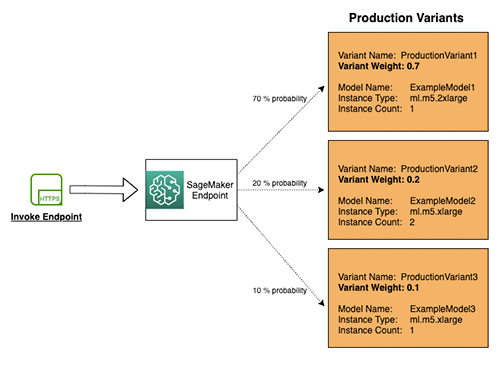

In [2]:
from IPython.display import Image
file_name1 = './img/variant.gif'
Image(file_name1)

### Solution 

You use a Jupyter notebook in Amazon SageMaker to create an endpoint that hosts two models (using ProductionVariant). Both models were trained using the Amazon SageMaker built-in XGBoost algorithm. For more information about how the models were trained. In the following use case, we trained each model on different subsets of the same dataset and used different versions of the XGBoost algorithm for each model
For detailed instructions, please refer to this [official notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb) 

In [3]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
import matplotlib.ticker as ticker
%matplotlib inline

from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import time
from datetime import datetime, timedelta
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs
import mxnet as mx
import seaborn as sns
import pickle
import gzip
import urllib
import csv
import shutil
import tqdm
import urllib.request
from tqdm import notebook
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map

import cv2

import sagemaker  
from sagemaker.s3 import S3Downloader, S3Uploader
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [5]:
sm_session   = sagemaker.Session()
bucket = sm_session.default_bucket()                     
prefix = 'ML-ABtesting'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

print('Sagemaker session :', sm_session)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000001BBAD316F08>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : ML-ABtesting
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


### 2. Upload our pre-trained models to Amazon S3. Create Variant models and deploy those

This code uploads two pre-trained XGBoost models that are ready for you to deploy. These models were trained using the XGB Churn Prediction Notebook in SageMaker. You can also use your own pre-trained models in this step. If you already have a pretrained model in Amazon S3, you can add it by specifying the s3_key. 

The models in this example are used to predict the probability of a mobile customer leaving their current mobile operator. The dataset we use is publicly available and was mentioned in the book Discovering Knowledge in Data by Daniel T. Larose. 

#### Define where the models are located in S3 bucket. Then upload it to S3
You use these locations when deploying the models in subsequent steps.

As stated above, we trained each model on different subsets of the same dataset as **'xgb-churn-prediction-model.tar'** and **'xgb-churn-prediction-model2.tar'**

In [6]:
model_url = S3Uploader.upload(local_path="./model/xgb-churn-prediction-model.tar.gz",
                              desired_s3_uri=f"s3://{bucket}/{prefix}")
model_url2 = S3Uploader.upload(local_path="./model/xgb-churn-prediction-model2.tar.gz",
                              desired_s3_uri=f"s3://{bucket}/{prefix}")
model_url, model_url2

('s3://sagemaker-us-west-2-570447867175/ML-ABtesting/xgb-churn-prediction-model.tar.gz',
 's3://sagemaker-us-west-2-570447867175/ML-ABtesting/xgb-churn-prediction-model2.tar.gz')

In [7]:
# You use these model objects to deploy on production variants on an endpoint.
# You can develop the models by training ML models on different datasets, different algorithms, different ML frameworks, and different hyperparameters
from sagemaker.amazon.amazon_estimator import get_image_uri

model_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"DEMO-xgb-churn-pred2-{datetime.now():%Y-%m-%d-%H-%M-%S}"

image_uri = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')
image_uri2 = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-2')

sm_session.create_model(name=model_name, 
                        role=role, 
                        container_defs={
                            'Image': image_uri,
                            'ModelDataUrl': model_url
                        }
                       )

sm_session.create_model(name=model_name2, 
                        role=role, 
                        container_defs={
                            'Image': image_uri2,
                            'ModelDataUrl': model_url2
                        }
                       )

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').
	get_image_uri(region, 'xgboost', '1.0-1').


'DEMO-xgb-churn-pred2-2020-07-29-15-18-50'

#### Create variants
We now create two variants, each with its own different model (these could also have different instance types and counts).

We set an initial_weight of “1” for both variants: this means 50% of our requests go to Variant1, and the remaining 50% of all requests to Variant2. (The sum of weights across both variants is 2 and each variant has weight assignment of 1. This implies each variant receives 1/2, or 50%, of the total traffic.)

In [8]:
from sagemaker.session import production_variant

variant1 = production_variant(model_name=model_name,
                              instance_type="ml.m4.xlarge",
                              initial_instance_count=1,
                              variant_name='Variant1',
                              initial_weight=1)

variant2 = production_variant(model_name=model_name2,
                              instance_type="ml.m4.xlarge",
                              initial_instance_count=1,
                              variant_name='Variant2',
                              initial_weight=1)

variant1, variant2

({'ModelName': 'DEMO-xgb-churn-pred-2020-07-29-15-18-50',
  'InstanceType': 'ml.m4.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant1',
  'InitialVariantWeight': 1},
 {'ModelName': 'DEMO-xgb-churn-pred2-2020-07-29-15-18-50',
  'InstanceType': 'ml.m4.xlarge',
  'InitialInstanceCount': 1,
  'VariantName': 'Variant2',
  'InitialVariantWeight': 1})

#### Deploy the models

In [9]:
endpoint_name = f"DEMO-xgb-churn-pred-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"EndpointName={endpoint_name}")

sm_session.endpoint_from_production_variants(
    name=endpoint_name,
    production_variants=[variant1, variant2]
)

EndpointName=DEMO-xgb-churn-pred-2020-07-29-15-19-23
----------------!

'DEMO-xgb-churn-pred-2020-07-29-15-19-23'

### 3. Invoke the deployed models

You can now send data to this endpoint and get inferences in real time. For this post, we use both approaches for testing models supported in Amazon SageMaker: distributing traffic to variants and invoking specific variants.

Amazon SageMaker distributes the traffic between production variants on an endpoint based on the respective weights that you configured in the preceding variant definitions. See the following code where we invoke the endpoint:

In [10]:
# get a subset of test data for a quick test
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

with open('./data/abtest/test_sample_tail_input_cols.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload)
        time.sleep(0.5)
        
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2020-07-29-15-19-23. 
Please wait...
........................................................................................................................Done!


#### Invocations per variant
Amazon SageMaker emits metrics such as Latency and Invocations for each variant in Amazon CloudWatch. Let’s query CloudWatch to get number of Invocations per variant, to show how invocations are split across variants:

In [16]:
cw = boto3.Session().client("cloudwatch")

def get_invocation_metrics_for_endpoint_variant(endpoint_name,
                                                variant_name,
                                                start_time,
                                                end_time):
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName="Invocations",
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[
            {
                "Name": "EndpointName",
                "Value": endpoint_name
            },
            {
                "Name": "VariantName",
                "Value": variant_name
            }
        ]
    )
    return pd.DataFrame(metrics["Datapoints"])\
            .set_index("Timestamp")\
            .sort_values("Timestamp")\
            .drop("Unit", axis=1)\
            .rename(columns={"Sum": variant_name})
#            .drop_duplicates(subset='Timestamp', keep="last")\

def plot_endpoint_metrics(start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metrics_variant1 = get_invocation_metrics_for_endpoint_variant(endpoint_name, variant1["VariantName"], start_time, end_time)
    metrics_variant2 = get_invocation_metrics_for_endpoint_variant(endpoint_name, variant2["VariantName"], start_time, end_time)
    metrics_variants = metrics_variant1.join(metrics_variant2, how="outer")
    metrics_variants.plot()
    return metrics_variants

In [ ]:
print("Waiting a minute for initial metric creation...")
time.sleep(60)
plot_endpoint_metrics()

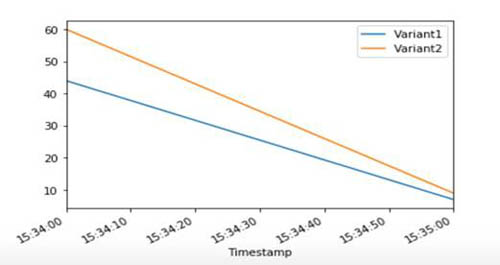

In [18]:
# It should look like this
file_name2 = './img/targeted-routing-005.jpg'
Image(file_name2)

### 4. Evaluate variant performance

#### Invoke a specific variant
Now, let’s use the new feature that was released today to invoke a specific variant. For this, we simply use the new parameter to define which specific ProductionVariant we want to invoke. Let us use this to invoke Variant1 for all requests.

#### Evaluating Variant 1
Using the new targeting feature, let us evaluate the accuracy, precision, recall, F1 score, and ROC/AUC for Variant1:

In [19]:
predictions = ''

print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('./data/abtest/test_sample_tail_input_cols.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload,
                                   TargetVariant=variant1["VariantName"]) # <- Note this new parameter
        
        predictions = ','.join([predictions, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

# Convert our predictions to a numpy array
pred_np = np.fromstring(predictions[1:], sep=',')
        
# Convert the prediction probabilities to binary predictions of either 1 or 0
threshold = 0.5
preds = np.where(pred_np > threshold, 1, 0)    
print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2020-07-29-15-19-23. 
Please wait...
........................................................................................................................Done!


#### When we again check the traffic per variant, this time we see that the number of invocations only incremented for Variant1, because all invocations were targeted at that variant:

In [ ]:
time.sleep(20) #let metrics catch up
plot_endpoint_metrics()

Accuracy: 0.9583333333333334
Precision: 0.9411764705882353
Recall: 0.8
F1 Score: 0.8648648648648648
AUC is 0.895


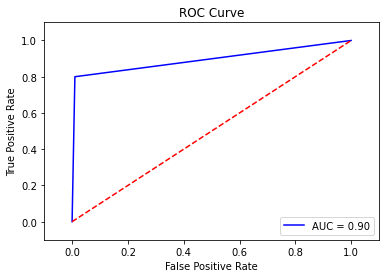

In [20]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Let's get the labels of our test set; we will use these to evaluate our predictions

df_with_labels = pd.read_csv('./data/abtest/test_dataset_sample_tail.csv')
test_labels = df_with_labels.iloc[:, 0]
labels = test_labels.to_numpy()

# Calculate accuracy
accuracy = sum(preds == labels) / len(labels)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = sum(preds[preds == 1] == labels[preds == 1]) / len(preds[preds == 1])
print(f'Precision: {precision}')

# Calculate recall
recall = sum(preds[preds == 1] == labels[preds == 1]) / len(labels[labels == 1])
print(f'Recall: {recall}')

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1_score}')

# Calculate AUC
auc = round(roc_auc_score(labels, preds), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(labels, preds)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Evaluating Variant 2
Same evaluate the accuracy, precision, recall, F1 score, and ROC/AUC for Variant1:

In [21]:
predictions2 = ''
print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")
with open('./data/abtest/test_sample_tail_input_cols.csv', 'r') as f:
    for row in f:
        print(".", end="", flush=True)
        payload = row.rstrip('\n')
        response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType="text/csv",
                                   Body=payload,
                                   TargetVariant=variant2["VariantName"])
        predictions2 = ','.join([predictions2, response['Body'].read().decode('utf-8')])
        time.sleep(0.5)

# Convert to numpy array        
pred_np2 = np.fromstring(predictions2[1:], sep=',')
        
# Convert to binary predictions
thresh = 0.5
preds2 = np.where(pred_np2 > threshold, 1, 0)    

print("Done!")

Sending test traffic to the endpoint DEMO-xgb-churn-pred-2020-07-29-15-19-23. 
Please wait...
........................................................................................................................Done!


In [ ]:
time.sleep(60) # give metrics time to catch up
plot_endpoint_metrics()

Accuracy: 0.9583333333333334
Precision: 0.8947368421052632
Recall: 0.85
F1 Score: 0.8717948717948718
AUC is 0.915


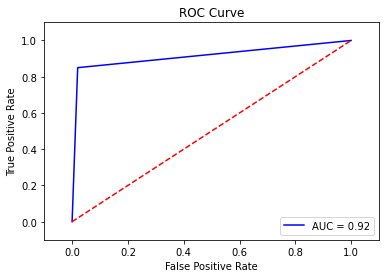

In [22]:
# Calculate accuracy
accuracy2 = sum(preds2 == labels) / len(labels)
print(f'Accuracy: {accuracy2}')

# Calculate precision
precision2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(preds2[preds2 == 1])
print(f'Precision: {precision2}')

# Calculate recall
recall2 = sum(preds2[preds2 == 1] == labels[preds2 == 1]) / len(labels[labels == 1])
print(f'Recall: {recall2}')

# Calculate F1 score
f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print(f'F1 Score: {f1_score2}')

auc2 = round(roc_auc_score(labels, preds2), 4)
print('AUC is ' + repr(auc2))

fpr2, tpr2, _ = metrics.roc_curve(labels, preds2)

plt.title('ROC Curve')
plt.plot(fpr2, tpr2, 'b',
label='AUC = %0.2f'% auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### We see that Variant2 is performing better for most of our defined metrics, so this is the one we’re likely to choose to dial up in production.

### 5. Shifting more traffic to your chosen model in production

We can continue to use TargetVariant to continue invoking a chosen variant. A simpler approach is to update the weights assigned to each variant using UpdateEndpointWeightsAndCapacities. This changes the traffic distribution to your production variants without requiring updates to your endpoint.

Recall our variant weights are as follows:

In [23]:
{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

{'Variant1': 1.0, 'Variant2': 1.0}

#### We'll first write a method to easily invoke our endpoint (a copy of what we had been previously doing)

In [24]:
def invoke_endpoint_for_two_minutes():
    with open('./data/abtest/test-dataset-input-cols.csv', 'r') as f:
        for row in f:
            print(".", end="", flush=True)
            payload = row.rstrip('\n')
            response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                                  ContentType='text/csv', 
                                                  Body=payload)
            response['Body'].read()
            time.sleep(1)

In [25]:
# We invoke our endpoint for a bit, to show the even split in invocations:
invocation_start_time = datetime.now()
invoke_endpoint_for_two_minutes()

..............................................................................................................................................................................................................................................................................................................................................

In [ ]:
time.sleep(20) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

#### Now let us shift 75% of the traffic to Variant2 by assigning new weights to each variant using UpdateEndpointWeightsAndCapacities. Amazon SageMaker will now send 75% of the inference requests to Variant2 and remaining 25% of requests to Variant1.

In [26]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {
            "DesiredWeight": 25,
            "VariantName": variant1["VariantName"]
        },
        {
            "DesiredWeight": 75,
            "VariantName": variant2["VariantName"]
        }
    ]
)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:570447867175:endpoint/demo-xgb-churn-pred-2020-07-29-15-19-23',
 'ResponseMetadata': {'RequestId': '078512cd-f3f7-4058-9f9a-871c6f7fd84a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '078512cd-f3f7-4058-9f9a-871c6f7fd84a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '107',
   'date': 'Wed, 29 Jul 2020 23:05:49 GMT'},
  'RetryAttempts': 0}}

In [27]:
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
....................................................Done


{'Variant1': 25.0, 'Variant2': 75.0}

#### Now let's check how that has impacted invocation metrics:

In [28]:
invoke_endpoint_for_two_minutes()

..............................................................................................................................................................................................................................................................................................................................................

In [ ]:
time.sleep(20) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

#### We can continue to monitor our metrics and when we're satisfied with a variant's performance, we can route 100% of the traffic over the variant. We used UpdateEndpointWeightsAndCapacities to update the traffic assignments for the variants. The weight for Variant1 is set to 0 and the weight for Variant2 is set to 1. Therefore, Amazon SageMaker will send 100% of all inference requests to Variant2.

In [30]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=endpoint_name,
    DesiredWeightsAndCapacities=[
        {
            "DesiredWeight": 0,
            "VariantName": variant1["VariantName"]
        },
        {
            "DesiredWeight": 1,
            "VariantName": variant2["VariantName"]
        }
    ]
)
print("Waiting for update to complete")
while True:
    status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
    if status in ["InService", "Failed"]:
        print("Done")
        break
    print(".", end="", flush=True)
    time.sleep(1)

{
    variant["VariantName"]: variant["CurrentWeight"]
    for variant in sm.describe_endpoint(EndpointName=endpoint_name)["ProductionVariants"]
}

Waiting for update to complete
........................................................Done


{'Variant1': 0.0, 'Variant2': 1.0}

In [ ]:
invoke_endpoint_for_two_minutes()
time.sleep(20) # give metrics time to catch up
plot_endpoint_metrics(invocation_start_time)

The Amazon CloudWatch metrics for the total invocations for each variant below shows us that all inference requests are being processed by Variant2 and there are no inference requests processed by Variant1.

You can now safely update your endpoint and delete Variant1 from your endpoint. You can also continue testing new models in production by adding new variants to your endpoint and following steps 2 - 4.

### 6. Close AWS Instance

In [31]:
sm_session.delete_endpoint(endpoint_name)

## Conclusion
Amazon SageMaker enables us to easily A/B test ML models in production by running multiple production variants on an endpoint. You can use SageMaker’s capabilities to test models that have been trained using different training datasets, hyperparameters, algorithms, or ML frameworks; test how they perform on different instance types; or a combination of all of the above. 

You can provide the traffic distribution between the variants on an endpoint and Amazon SageMaker splits the inference traffic to the variants based on the specified distribution. Alternately, if you want to test models for specific customer segments, you can specify the variant that should process an inference request by providing the TargetVariant header, and Amazon SageMaker will route the request to the variant that you specified.

Referenence:
https://aws.amazon.com/ko/blogs/machine-learning/a-b-testing-ml-models-in-production-using-amazon-sagemaker/